## Stock Price Forecasting with LSTM
In this project, we aim to predict stock prices using a Long Short-Term Memory (LSTM) neural network. LSTM networks are a type of recurrent neural network (RNN) that are well-suited for time series forecasting due to their ability to remember long-term dependencies. Here, we will walk through the process of data preprocessing, model building, training, and evaluating the performance of our LSTM model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

#### Load and Visualize the Data

We start by loading the stock price data from a CSV file. This dataset contains historical stock prices of Amazon company.

In [3]:
data = pd.read_csv(r"data\AMZN.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [4]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

C:\Users\punee\AppData\Local\Temp\ipykernel_31320\1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


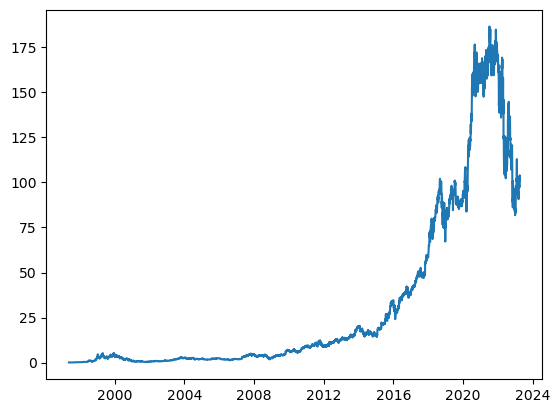

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

#### Prepare Data for LSTM

To train an LSTM model, we need to structure the data in a way that includes the historical context. This involves creating lagged features of the stock prices.

The following function `prepare_data_for_lstm` takes the original dataframe and a specified number of steps (lookback period) to generate these lagged features.

In [7]:
from copy import deepcopy as dc

def prepare_data_for_lstm (df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    df.set_index('Date', inplace=True)

    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_data_for_lstm(data,lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [8]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

#### Scaling the Data

Before feeding the data into the LSTM model, it's essential to scale it to a range that the model can handle effectively. We use the `MinMaxScaler` from scikit-learn to scale the data to the range of -1 to 1.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

#### Extract Features and Target Variables

In this step, we separate the dataset into features (X) and target (y) variables. The target variable is the stock price we aim to predict, while the features are the lagged stock prices.


In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

### Flip the Feature Data

To ensure the LSTM model correctly interprets the sequence of data, we flip the feature data along the time axis. This step is crucial for maintaining the chronological order of the lagged stock prices.

In [11]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

#### Split the Data into Training and Testing Sets

To evaluate the performance of our LSTM model, we need to split the data into training and testing sets. We typically use a majority of the data for training and a smaller portion for testing.

In [12]:
split_index = int(len(X) * 0.95)

split_index

6183

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

#### Reshape the Data for LSTM

The LSTM model expects the input data to be in a specific 3D shape: `[samples, time steps, features]`. We need to reshape our training and testing datasets accordingly.

Why Reshape the Data?
LSTM models require the input data to be in a specific 3D shape: [samples, time steps, features]. Let's break down each component:

- Samples: The number of samples or sequences in the dataset. Each sample corresponds to a single instance in the dataset.
- Time Steps: The number of time steps in each sample. This corresponds to the lookback period, which in this case is 7.
- Features: The number of features at each time step. In this case, we have only one feature: the stock price.

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

#### Convert Data to PyTorch Tensors

To use PyTorch for training our LSTM model, we need to convert the data from NumPy arrays to PyTorch tensors. This step ensures that the data is in the correct format for the PyTorch library.

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

#### Create a Custom Dataset Class

To efficiently handle and iterate over the time series data during training, we create a custom dataset class by extending `torch.utils.data.Dataset`. This custom class allows us to define how the data is accessed and ensures compatibility with PyTorch's DataLoader for batching.

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

#### Create DataLoaders for Training and Testing

To facilitate efficient data loading during training and testing, we use PyTorch's `DataLoader` class. DataLoaders handle batching, shuffling, and parallel data loading, which can significantly improve the performance and ease of training our model.

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Load a Batch of Data and Move to Device

In this step, we demonstrate how to load a batch of data from the DataLoader and move it to the appropriate device (CPU or GPU) for training. This is a crucial step in the training loop of a neural network.

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### LSTM Model Architecture

The LSTM model we have defined consists of the following components:

Input Size:
`input_size = 1`: Each input time step has a single feature (the stock price).

Hidden Size:
`hidden_size = 4`: The number of features in the hidden state of the LSTM.
Number of Stacked Layers:
`num_stacked_layers = 1`: The number of LSTM layers stacked on top of each other. In this case, we use a single LSTM layer.

#### Model Components:

LSTM Layer:
`self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)`:
- This defines the LSTM layer with the specified input size, hidden size, and number of stacked layers.
- `batch_first=True` ensures that the input tensor shape is `[batch_size, time_steps, input_size]`.

Fully Connected Layer:
`self.fc = nn.Linear(hidden_size, 1)`:
- This defines a fully connected layer that maps the hidden state of the LSTM to the output prediction (stock price).

#### Forward Pass:

Initialize Hidden and Cell States:
- `h0` and `c0` are initialized to zeros with the shape `[num_stacked_layers, batch_size, hidden_size]`.
- These states are moved to the device (CPU or GPU).

LSTM Layer Output:
`out, _ = self.lstm(x, (h0, c0))`:
- The input tensor `x` is passed through the LSTM layer along with the initial hidden and cell states.
- `out` contains the output features from the LSTM for each time step.

Fully Connected Layer Output:
`out = self.fc(out[:, -1, :])`:
- Only the output from the last time step is passed through the fully connected layer to generate the final prediction.


In [22]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Train the Model for One Epoch

The `train_one_epoch` function handles the training process for one epoch. An epoch is one complete pass through the entire training dataset. This function will:
- Set the model to training mode
- Iterate over the training data in batches
- Perform the forward pass
- Compute the loss
- Perform the backward pass and optimize the model parameters

In [23]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

#### Validate the Model for One Epoch

The `validate_one_epoch` function handles the validation process for one epoch. Validation is the process of evaluating the model on a separate dataset that the model has not seen during training. This helps in monitoring the model's performance and detecting issues like overfitting.

In [24]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

#### Training and Validation Loop

In this final step, we define the overall training and validation loop. This loop will run for a specified number of epochs, training the model and then validating its performance on a separate dataset. We will define the loss function, optimizer, and execute the `train_one_epoch` and `validate_one_epoch` functions in each iteration.

In [25]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.384
Batch 200, Loss: 0.079
Batch 300, Loss: 0.038

Val Loss: 0.135
***************************************************

Epoch: 2
Batch 100, Loss: 0.029
Batch 200, Loss: 0.024
Batch 300, Loss: 0.017

Val Loss: 0.033
***************************************************

Epoch: 3
Batch 100, Loss: 0.010
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003

Val Loss: 0.008
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.008
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
*****************

#### Plot Actual vs. Predicted Stock Prices

After training the model, we can visualize its performance by plotting the actual and predicted stock prices for the training dataset. This helps in understanding how well the model has learned to predict stock prices.

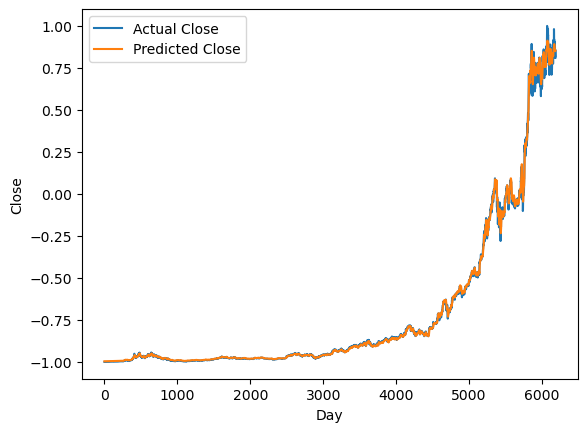

In [26]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

#### Inverse Scale Predictions

After obtaining the predictions from the model, we need to inverse scale them back to the original scale of the stock prices. This step ensures that the predictions are in the same range as the actual stock prices, making them comparable.

In [27]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.43034352,   0.42940975,   0.4289651 , ..., 172.80895564,
       172.5683834 , 172.79100846])

#### Inverse Scale Actual Values

In addition to inverse scaling the predictions, we also need to inverse scale the actual values. This ensures that both the predictions and the actual values are on the same scale, allowing for a meaningful comparison.

In [28]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

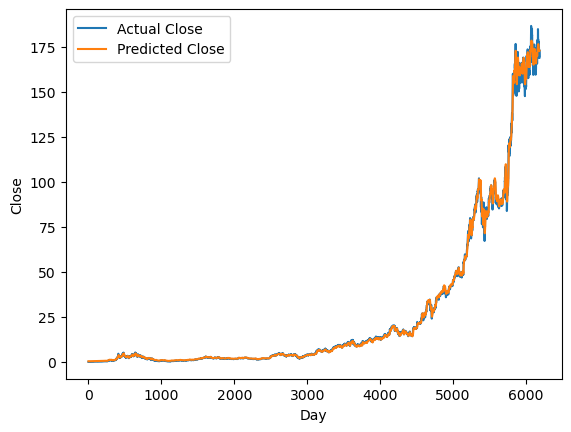

In [29]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


#### Inverse Scale Test Predictions

After obtaining the test predictions from the model, we need to inverse scale them back to the original scale of the stock prices. This step ensures that the predictions are in the same range as the actual stock prices, making them comparable.

In [30]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([172.17016612, 171.73877795, 171.07171425, 171.01593293,
       171.20401425, 171.40441794, 171.13207547, 171.29259406,
       171.17158816, 171.18331025, 170.74065021, 170.79776548,
       170.45212248, 169.78973316, 168.96545239, 168.20196637,
       167.36798112, 167.34532065, 167.00694212, 166.2819461 ,
       166.01433359, 165.33909389, 164.32914402, 162.67386827,
       159.04103456, 155.92735178, 152.46755355, 148.90374617,
       146.12696346, 144.73727707, 145.09245781, 146.79821243,
       148.09104298, 147.47020619, 150.52918592, 153.48755251,
       156.34188216, 158.31634424, 159.53396782, 159.62732762,
       161.16297033, 160.94277972, 161.00322987, 160.11520854,
       158.92159605, 157.55918337, 155.81972428, 155.25254561,
       155.08853096, 154.75287591, 154.366553  , 154.39552194,
       153.87625429, 153.49575074, 150.76108193, 147.63671644,
       145.44394239, 145.1939936 , 144.73348087, 144.06880716,
       144.72158648, 147.36746428, 150.82670113, 154.43

#### Inverse Scale Actual Test Values

In addition to inverse scaling the test predictions, we also need to inverse scale the actual test values. This ensures that both the predictions and the actual values are on the same scale, allowing for a meaningful comparison.

In [31]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

#### Plot Actual vs. Predicted Stock Prices for Test Data

After inverse scaling the test predictions and actual test values, we can visualize the model's performance by plotting them. This helps in understanding how well the model generalizes to unseen data.

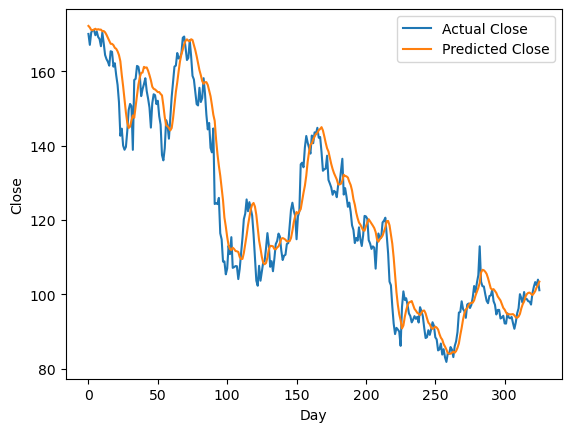

In [32]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
